In [1]:
!pip install networkx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

     |████████████████████████████████| 1.9 MB 10.0 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


## Load data


In [2]:
df_classes = pd.read_csv("data/elliptic_txs_classes.csv")
df_edges = pd.read_csv("data/elliptic_txs_edgelist.csv")
df_features = pd.read_csv("data/elliptic_txs_features.csv", header=None)

In [3]:
df_features.head(2)

0    1         2         3         4        5         6         7    \
0  230425980    1 -0.171469 -0.184668 -1.201369 -0.12197 -0.043875 -0.113002   
1    5530458    1 -0.171484 -0.184668 -1.201369 -0.12197 -0.043875 -0.113002   

        8         9    ...       157       158       159       160       161  \
0 -0.061584 -0.162097  ... -0.562153 -0.600999  1.461330  1.461369  0.018279   
1 -0.061584 -0.162112  ...  0.947382  0.673103 -0.979074 -0.978556  0.018279   

       162       163       164       165       166  
0 -0.08749 -0.131155 -0.097524 -0.120613 -0.119792  
1 -0.08749 -0.131155 -0.097524 -0.120613 -0.119792  

[2 rows x 167 columns]

In [4]:
df_edges.head(2)

txId1      txId2
0  230425980    5530458
1  232022460  232438397

In [5]:
df_classes.head(2)

txId    class
0  230425980  unknown
1    5530458  unknown

Change column names

In [6]:
colNames1 = {'0': 'txId', 1: "Time step"}
colNames2 = {str(ii+2): "Local_feature_" + str(ii+1) for ii in range(93)}
colNames3 = {str(ii+95): "Aggregate_feature_" + str(ii+1) for ii in range(72)}

colNames = dict(colNames1, **colNames2, **colNames3 )
colNames = {int(jj): item_kk for jj,item_kk in colNames.items()}

df_features = df_features.rename(columns=colNames)
df_features.head()

txId  Time step  Local_feature_1  Local_feature_2  Local_feature_3  \
0  230425980          1        -0.171469        -0.184668        -1.201369   
1    5530458          1        -0.171484        -0.184668        -1.201369   
2  232022460          1        -0.172107        -0.184668        -1.201369   
3  232438397          1         0.163054         1.963790        -0.646376   
4  230460314          1         1.011523        -0.081127        -1.201369   

   Local_feature_4  Local_feature_5  Local_feature_6  Local_feature_7  \
0        -0.121970        -0.043875        -0.113002        -0.061584   
1        -0.121970        -0.043875        -0.113002        -0.061584   
2        -0.121970        -0.043875        -0.113002        -0.061584   
3        12.409294        -0.063725         9.782742        12.414558   
4         1.153668         0.333276         1.312656        -0.061584   

   Local_feature_8  ...  Aggregate_feature_63  Aggregate_feature_64  \
0        -0.162097  ...             -0.562153             -0.600999   
1        -0.162112  ...              0.947382              0.673103   
2        -0.162749  ...              0.670883              0.439728   
3        -0.163645  ...             -0.577099             -0.613614   
4        -0.163523  ...             -0.511871             -0.400422   

   Aggregate_feature_65  Aggregate_feature_66  Aggregate_feature_67  \
0              1.461330              1.461369              0.018279   
1             -0.979074             -0.978556              0.018279   
2             -0.979074             -0.978556             -0.098889   
3              0.241128              0.241406              1.072793   
4              0.517257              0.579382              0.018279   

   Aggregate_feature_68  Aggregate_feature_69  Aggregate_feature_70  \
0             -0.087490             -0.131155             -0.097524   
1             -0.087490             -0.131155             -0.097524   
2             -0.106715             -0.131155             -0.183671   
3              0.085530             -0.131155              0.677799   
4              0.277775              0.326394              1.293750   

   Aggregate_feature_71  Aggregate_feature_72  
0             -0.120613             -0.119792  
1             -0.120613             -0.119792  
2             -0.120613             -0.119792  
3             -0.120613             -0.119792  
4              0.178136              0.179117  

[5 rows x 167 columns]

Change class 'unknown' to 3

In [7]:
df_classes.loc[df_classes['class'] == 'unknown', 'class'] = 3

In [8]:
""" print dimensions """
print('Shape of classes', df_classes.shape)
print('Shape of edges', df_edges.shape)
print('Shape of features', df_features.shape)

Shape of classes (203769, 2)
Shape of edges (234355, 2)
Shape of features (203769, 167)


## Exploratory data analysis


<BarContainer object of 3 artists>

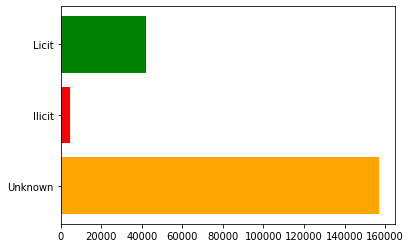

In [9]:
group_class = df_classes.groupby('class').count()
plt.barh(['Unknown','Ilicit','Licit'], group_class['txId'].values, color=['orange', 'r', 'g'] )

Number of transactions per time stap

Text(0.5, 1.0, 'Number of transactions by Time step')

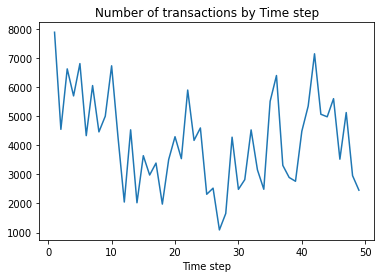

In [10]:
group_feature = df_features.groupby('Time step').count()
group_feature['txId'].plot()
plt.title('Number of transactions by Time step')

In [11]:
# Merge class and features
df_class_feature = pd.merge(df_classes, df_features)
df_class_feature.head()

txId class  Time step  Local_feature_1  Local_feature_2  \
0  230425980     3          1        -0.171469        -0.184668   
1    5530458     3          1        -0.171484        -0.184668   
2  232022460     3          1        -0.172107        -0.184668   
3  232438397     2          1         0.163054         1.963790   
4  230460314     3          1         1.011523        -0.081127   

   Local_feature_3  Local_feature_4  Local_feature_5  Local_feature_6  \
0        -1.201369        -0.121970        -0.043875        -0.113002   
1        -1.201369        -0.121970        -0.043875        -0.113002   
2        -1.201369        -0.121970        -0.043875        -0.113002   
3        -0.646376        12.409294        -0.063725         9.782742   
4        -1.201369         1.153668         0.333276         1.312656   

   Local_feature_7  ...  Aggregate_feature_63  Aggregate_feature_64  \
0        -0.061584  ...             -0.562153             -0.600999   
1        -0.061584  ...              0.947382              0.673103   
2        -0.061584  ...              0.670883              0.439728   
3        12.414558  ...             -0.577099             -0.613614   
4        -0.061584  ...             -0.511871             -0.400422   

   Aggregate_feature_65  Aggregate_feature_66  Aggregate_feature_67  \
0              1.461330              1.461369              0.018279   
1             -0.979074             -0.978556              0.018279   
2             -0.979074             -0.978556             -0.098889   
3              0.241128              0.241406              1.072793   
4              0.517257              0.579382              0.018279   

   Aggregate_feature_68  Aggregate_feature_69  Aggregate_feature_70  \
0             -0.087490             -0.131155             -0.097524   
1             -0.087490             -0.131155             -0.097524   
2             -0.106715             -0.131155             -0.183671   
3              0.085530             -0.131155              0.677799   
4              0.277775              0.326394              1.293750   

   Aggregate_feature_71  Aggregate_feature_72  
0             -0.120613             -0.119792  
1             -0.120613             -0.119792  
2             -0.120613             -0.119792  
3             -0.120613             -0.119792  
4              0.178136              0.179117  

[5 rows x 168 columns]

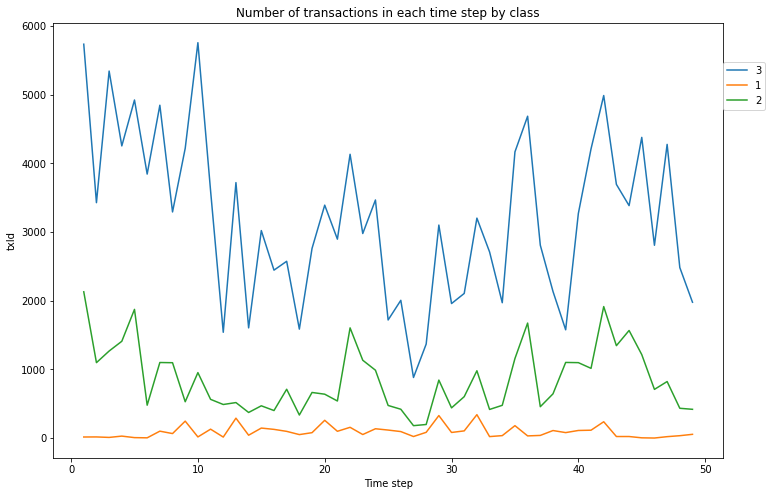

In [12]:
plt.figure(figsize=(12, 8))
grouped = df_class_feature.groupby(['Time step', 'class'])['txId'].count().reset_index().rename(columns={'id': 'count'})
sns.lineplot(x='Time step', y='txId', hue='class', data=grouped);
plt.legend(loc=(1.0, 0.8));
plt.title('Number of transactions in each time step by class');

In [13]:
group_class_feature = df_class_feature.groupby(["Time step", "class"]).count()
group_class_feature = group_class_feature['txId'].reset_index().rename(columns={'txId': 'count'})#unstack()
group_class_feature.head()

Time step class  count
0          1     3   5733
1          1     1     17
2          1     2   2130
3          2     3   3427
4          2     1     18

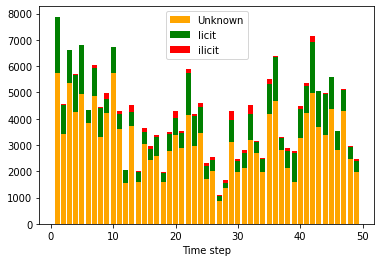

In [14]:
class1 = group_class_feature[group_class_feature['class'] == '1']
class2 = group_class_feature[group_class_feature['class'] == '2']
class3 = group_class_feature[group_class_feature['class'] == 3 ]

p1 = plt.bar(class3['Time step'], class3['count'], color = 'orange', label="Unknown")

p2 = plt.bar(class2['Time step'], class2['count'], color='g',
             bottom=class3['count'], label="licit")

p3 = plt.bar(class1['Time step'], class1['count'], color='r',
             bottom=np.array(class3['count'])+ np.array(class2['count']), label="ilicit")

plt.xlabel('Time step')

plt.legend()
plt.savefig("./fig/time_step.pdf")

## Graph

We build two separate directed graphs. One for the illicit transaction and another one for licit transaction. 
We chose the time step 29 (random choice).

In [15]:
time_step = 29
number_licit_trans = df_class_feature[ (df_class_feature["class"] == '2') & (df_class_feature["Time step"] == time_step)].shape[0]
number_ilicit_trans = df_class_feature[ (df_class_feature["class"] == '1') & (df_class_feature["Time step"] == time_step)].shape[0]
print(f"Time step: {time_step}\nNumber of licit transactions: {number_licit_trans}\nNumber illicit transactions: {number_ilicit_trans}")

Time step: 29
Number of licit transactions: 845
Number illicit transactions: 329


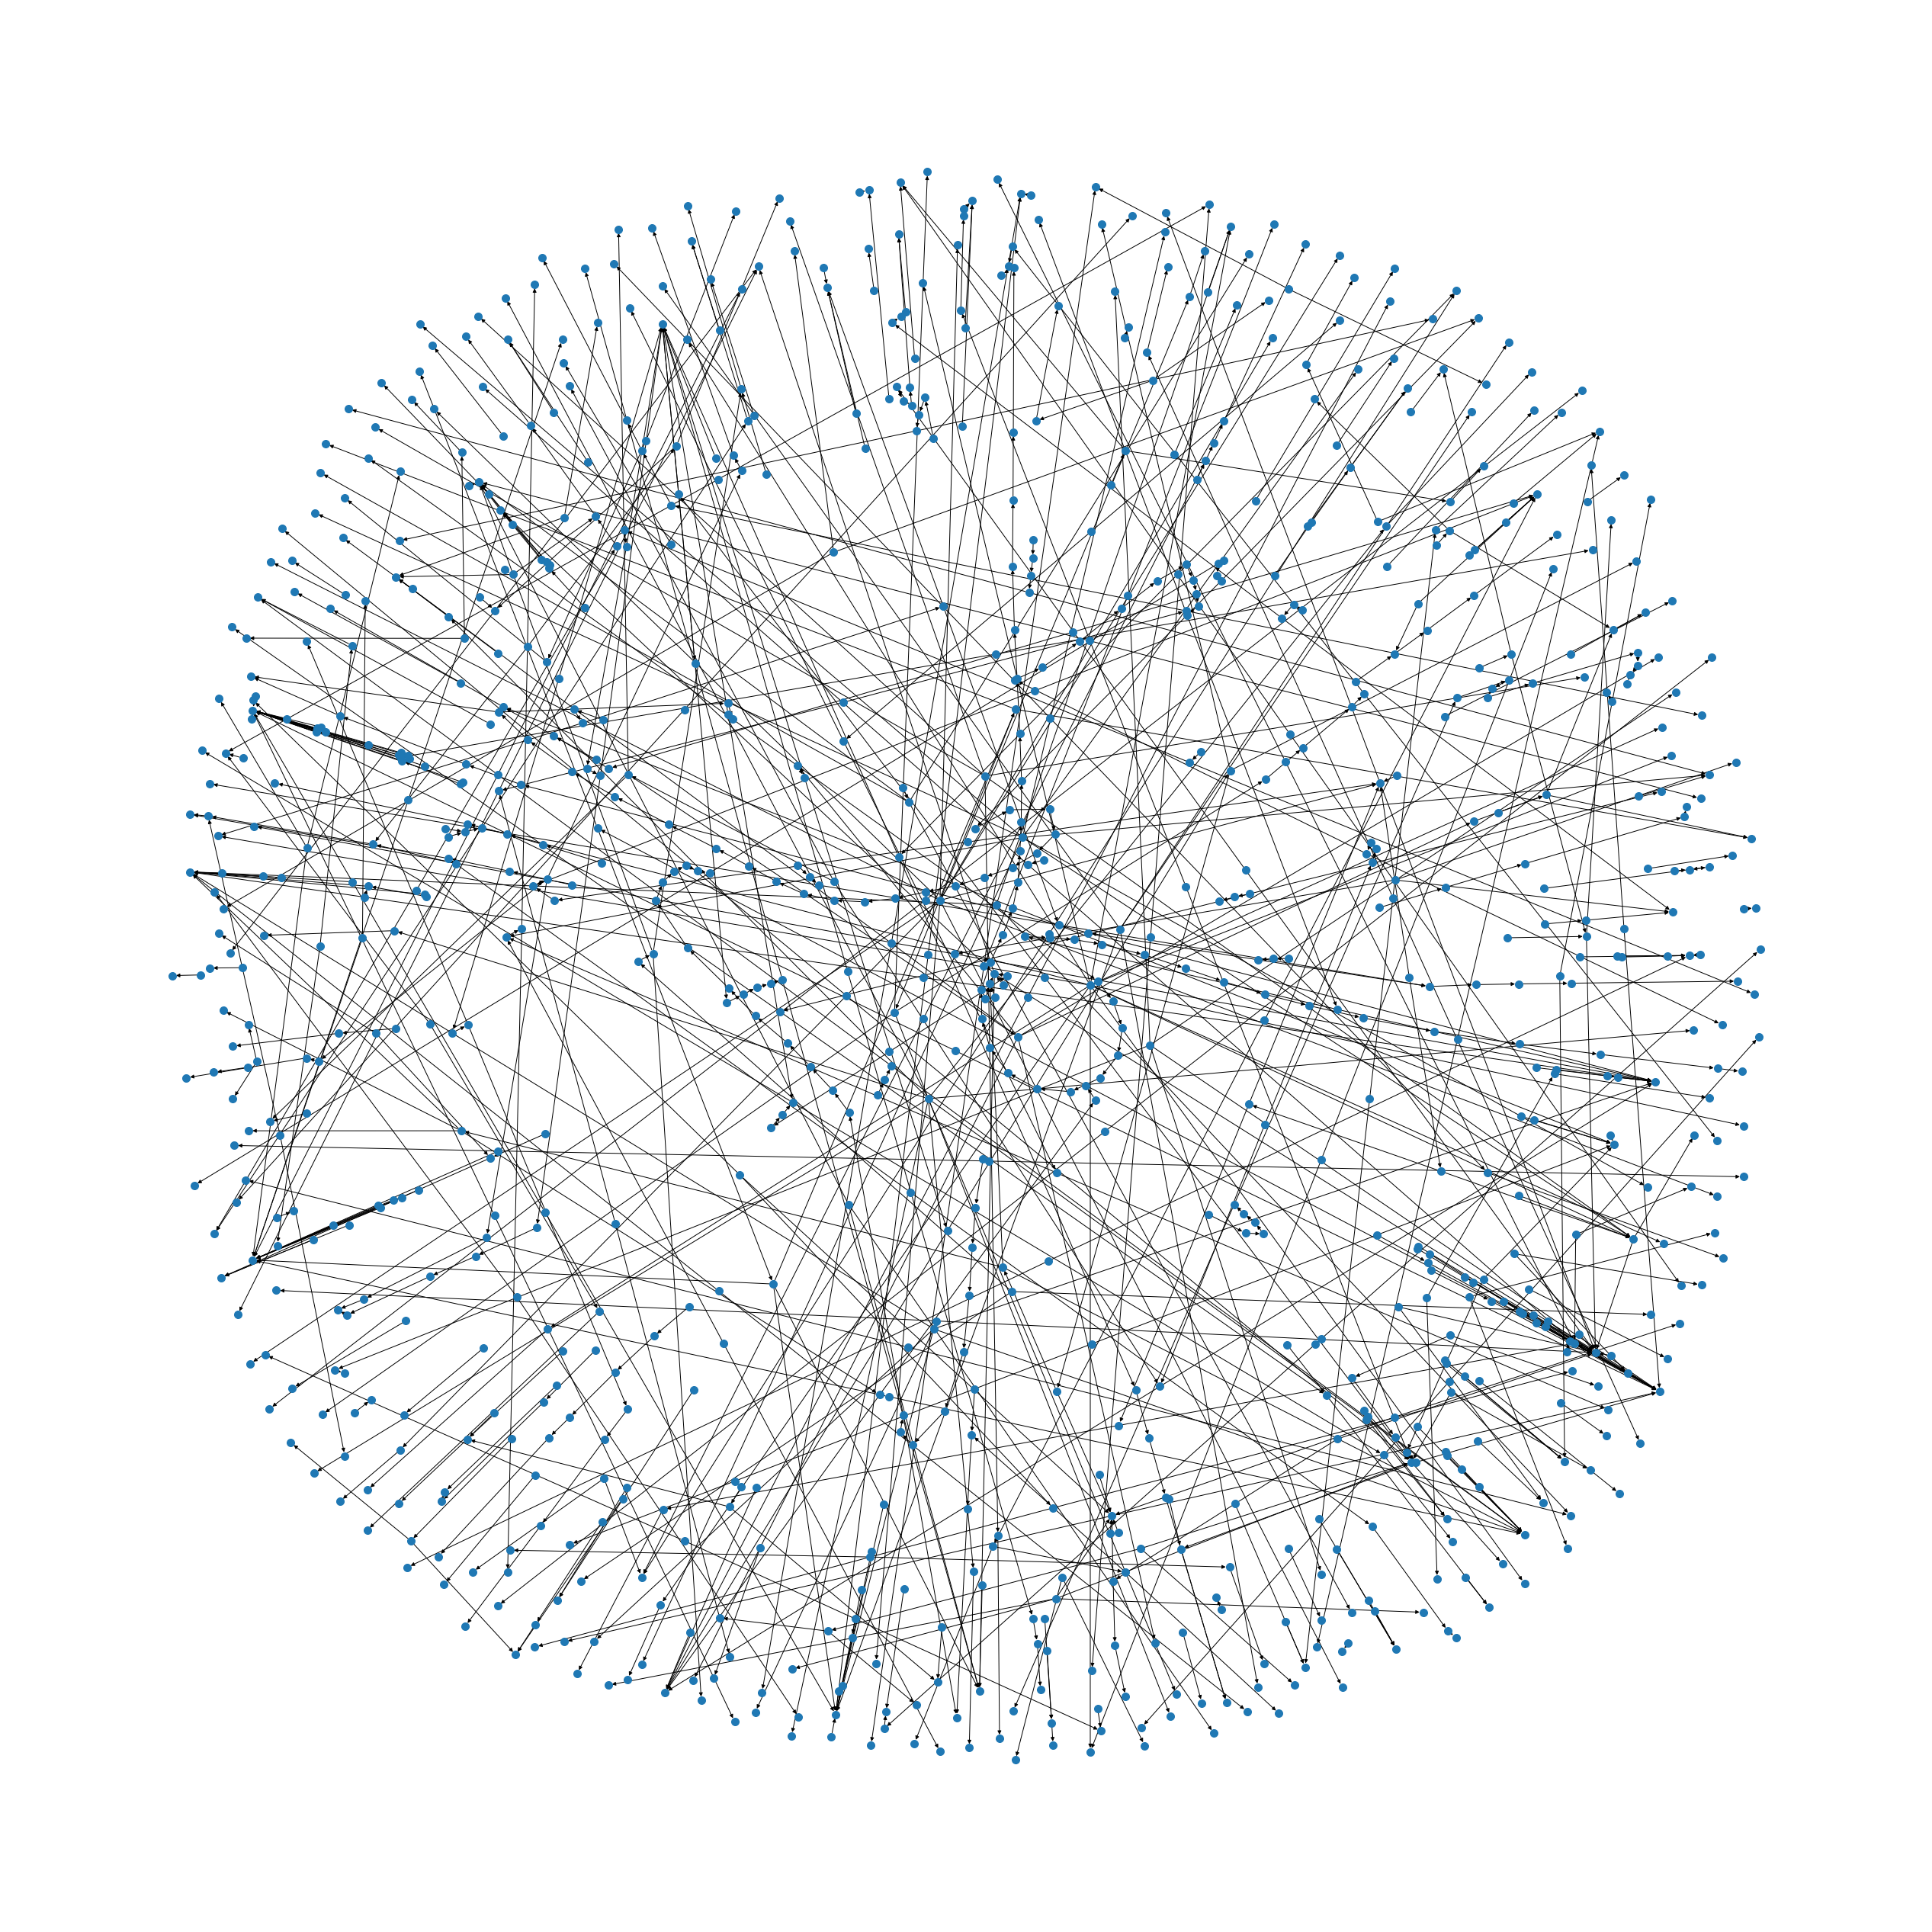

In [16]:
licit_ids = df_class_feature.loc[(df_class_feature['Time step'] == time_step) & (df_class_feature['class'] == '2'), 'txId']
licit_edges = df_edges.loc[df_edges['txId1'].isin(licit_ids)]

graph_l = nx.from_pandas_edgelist(licit_edges, source = 'txId1', target = 'txId2', 
                                 create_using = nx.DiGraph())
pos = nx.spring_layout(graph_l)
plt.figure(figsize=(35,35))
nx.draw(graph_l, with_labels=False, pos=pos, node_size=100, )

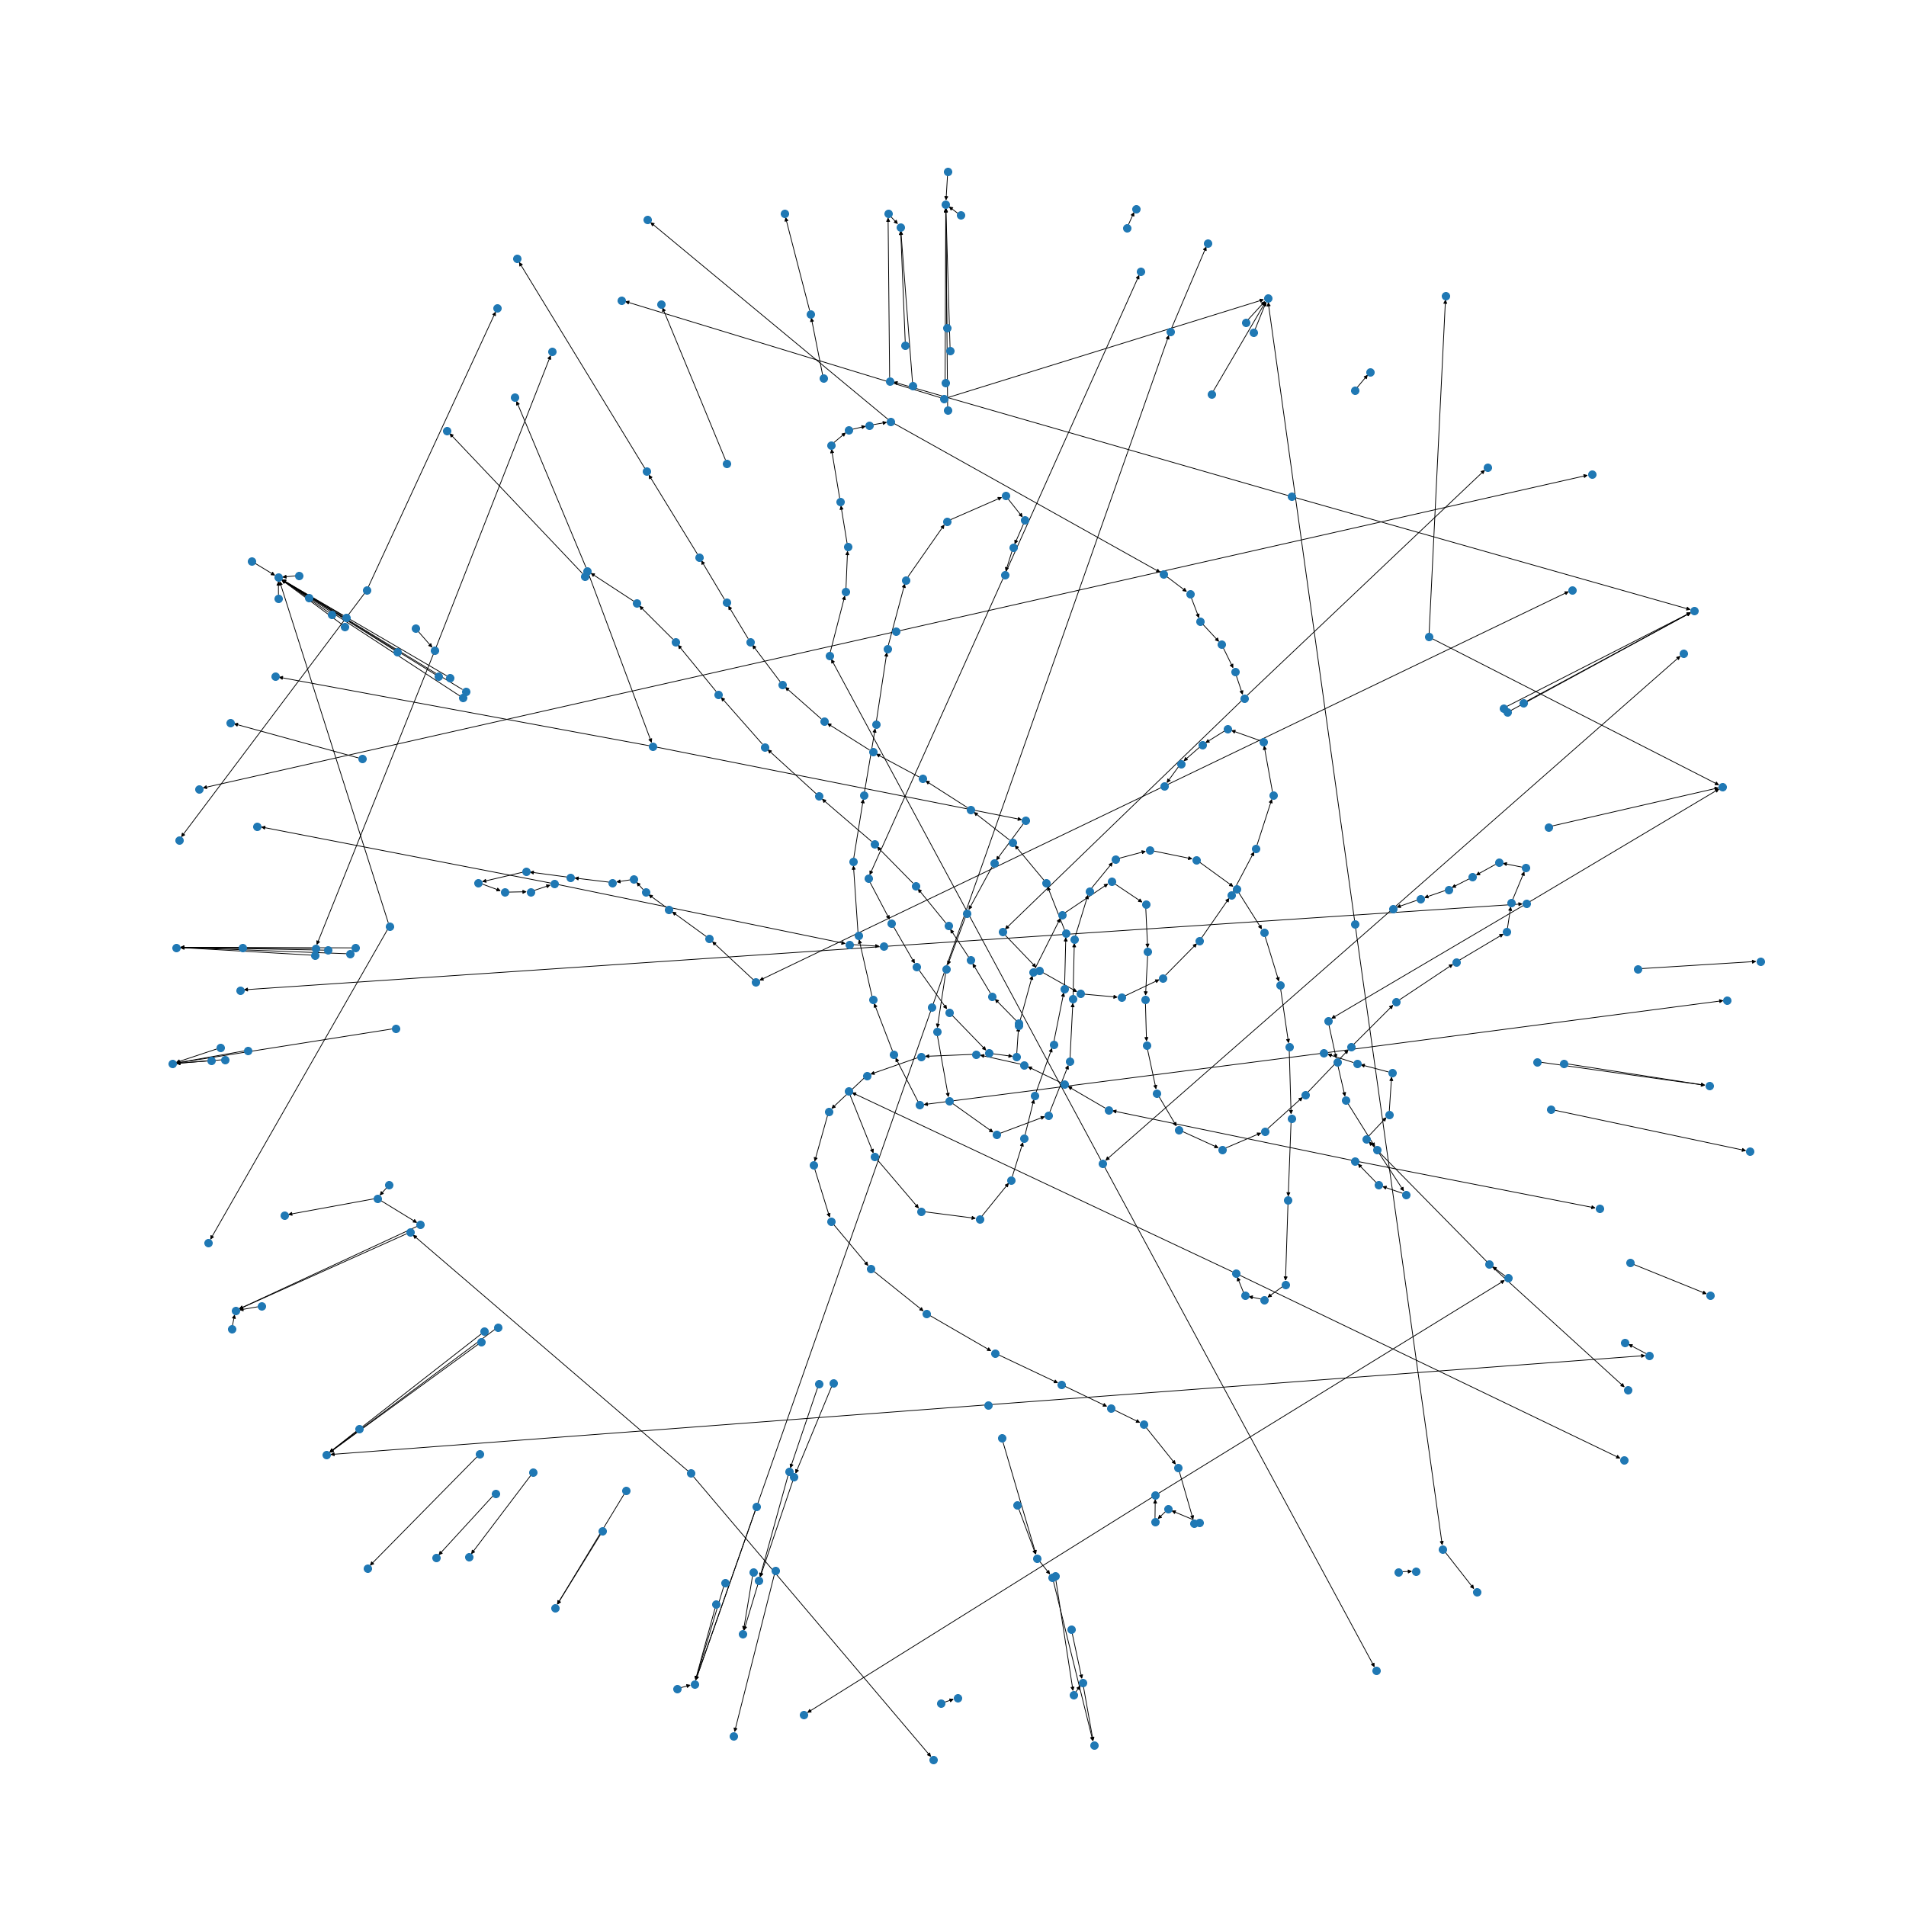

In [17]:
ilicit_ids = df_class_feature.loc[(df_class_feature['Time step'] == time_step) & (df_class_feature['class'] == '1'), 'txId']
ilicit_edges = df_edges.loc[df_edges['txId1'].isin(ilicit_ids)]

graph_ill = nx.from_pandas_edgelist(ilicit_edges, source = 'txId1', target = 'txId2', 
                                 create_using = nx.DiGraph())
pos = nx.spring_layout(graph_ill)
plt.figure(figsize=(35,35))
nx.draw(graph_ill, with_labels=False, pos=pos, node_size=100)

## Degree distribution

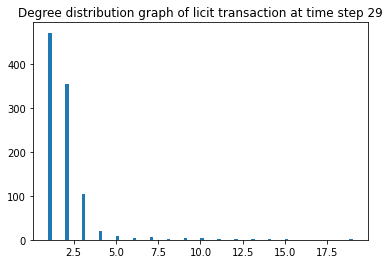

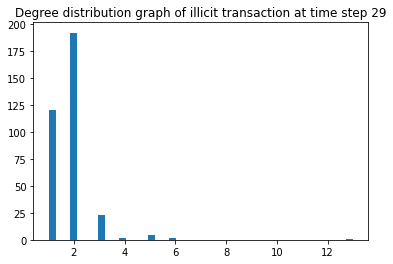

In [18]:
# degree distribution (histogram of how many edges each node has)
plt.figure(1)
plt.title(f"Degree distribution graph of licit transaction at time step {time_step}")
plt.hist([v for k,v in nx.degree(graph_l)], bins="auto");

plt.figure(2)
plt.title(f"Degree distribution graph of illicit transaction at time step {time_step}")
plt.hist([v for k,v in nx.degree(graph_ill)], bins="auto");

## Betweenness centrality
A node is important if it lies on many shortest paths between other nodes.

$c_{v} = \sum_{s\neq v \neq t} {\frac{\sigma_{st}(v)}{\sigma_{st}}}$.

$\sigma_{st}(v)$ is the number of shortest paths between s and t that contain v

$\sigma_{st}$ is the number of shrtest paths between s and t

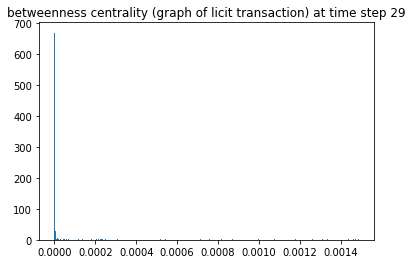

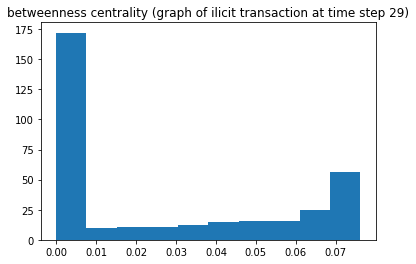

In [19]:
# betweenness centrality
plt.figure(1)
plt.title(f"betweenness centrality (graph of licit transaction) at time step {time_step}")
plt.hist(nx.centrality.betweenness_centrality(graph_l).values(), bins="auto");

plt.figure(2)
plt.title(f"betweenness centrality (graph of ilicit transaction at time step {time_step})")
plt.hist(nx.centrality.betweenness_centrality(graph_ill).values(), bins="auto");

We can state that for licit transactions the betweenness centrality is quite low. While for ilicit transactions the betweenness centrality is higher and many nodes have a betweenness centrality greater than 0.01.

## Closeness centrality

A node is important if it has small shortest path length to all other nodes.

$c_v= \frac{1}{\sum_{u\neq v}\sigma_{uv}}$

where $\sigma_{uv}$ is the shortest path length between $u$ and $v$.

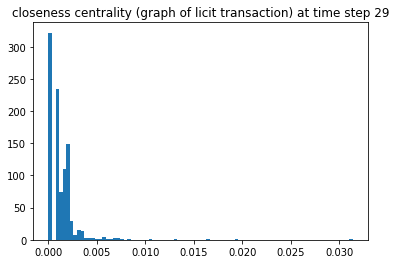

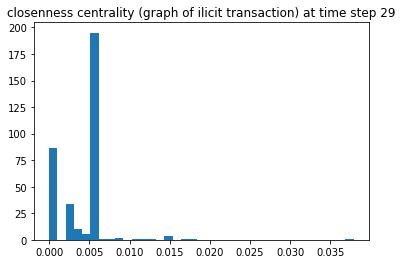

In [20]:
# closeness centrality
plt.figure(1)
plt.title(f"closeness centrality (graph of licit transaction) at time step {time_step}")
plt.hist(nx.centrality.closeness_centrality(graph_l).values(), bins="auto");

plt.figure(2)
plt.title(f"closenness centrality (graph of ilicit transaction) at time step {time_step}")
plt.hist(nx.centrality.closeness_centrality(graph_ill).values(), bins="auto");

## Eigenvector centrality
A node $v$ is important if surrounded by important neighboring nodes $u \in N(v)$. 

We model the centrality of node $v$ as the sum of the centrality of neighboring nodes:

$c_v = \frac{1}{\lambda}\sum_{u\in N(v)}c_u$ where $\lambda$ is some positive constant.



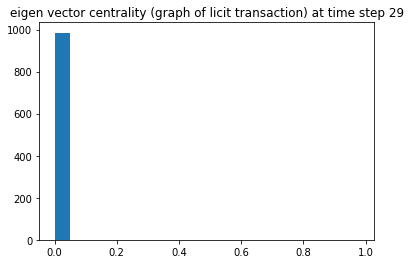

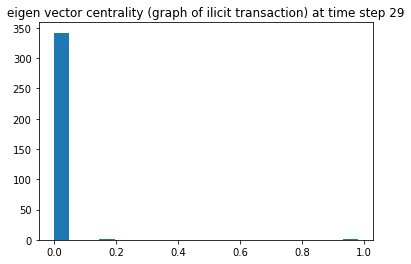

In [21]:
plt.figure(1)
plt.title(f"eigen vector centrality (graph of licit transaction) at time step {time_step}")
plt.hist(nx.centrality.eigenvector_centrality(graph_l, max_iter= 1000).values(), bins=20);

plt.figure(2)
plt.title(f"eigen vector centrality (graph of ilicit transaction) at time step {time_step}")
plt.hist(nx.centrality.eigenvector_centrality(graph_ill, max_iter= 2000).values(),bins=20);

 ## Clustering coefficient
The local clustering coefficient of a vertex (node) in a graph quantifies how close its neighbours are to being a clique (complete graph). 

We define $k_i$ as the number of vertices in the neighbourhood, $N_i$ of a vertex. The local clustering coefficient $C_i$ for a vertex $v_i$ is then given by a proportion of the number of links between the vertices within its neighbourhood divided by the number ok links that could possibly exist between them.

Thus, the local clustering coefficient for directed graphs is given as:

$C_i = \frac{|\{ e_{jk}: v_j, v_k \in N_i, e_{jk} \in E \}}{k_i(k_i-1)} $

The **global clustering coefficient** is the average of local clustering coefficients of all vertices $n$:

$C = \frac{1}{n}\sum_{i=1}^{n}C_i$


In [22]:
gc_l = nx.cluster.average_clustering(graph_l)
print(f"The global clustering coefficient for the licit graph is :{gc_l:.6f} at time step {time_step}")

The global clustering coefficient for the licit graph is :0.000349 at time step 29


In [23]:
gc_ill = nx.cluster.average_clustering(graph_ill)
print(f"The global clustering coefficient for the illicit graph is :{gc_ill:.6f} at time step {time_step}")

The global clustering coefficient for the illicit graph is :0.000000 at time step 29


The global clustering coefficient for the illicit graph is 0, this means that the neighbourhood of each node is not connected.

## Time step
In this section you can select a time step and visualize all useful insights:

- degree distribution

- betweenness centrality

- closenness centrality

- eigenvector centrality

- clustering coefficient

Time step: 32
Number of licit transactions: 981
Number illicit transactions: 342
The global clustering coefficient for the licit graph is :0.000273 at time step 32
The global clustering coefficient for the illicit graph is :0.000000 at time step 32


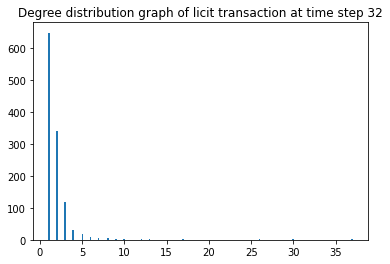

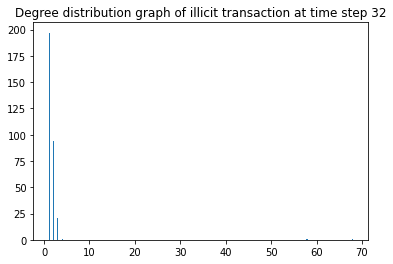

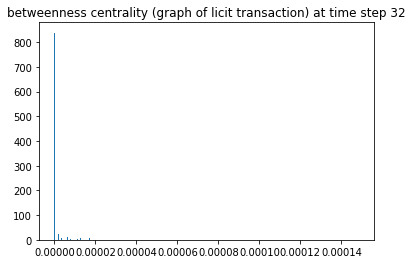

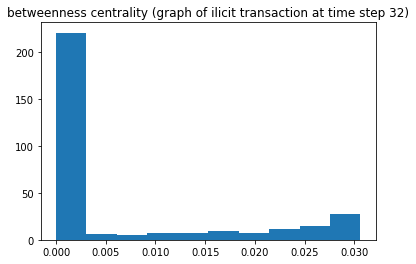

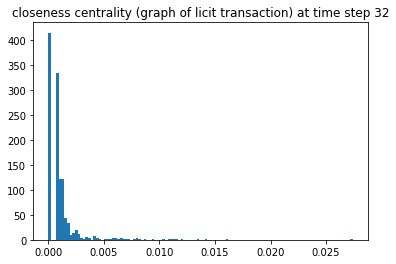

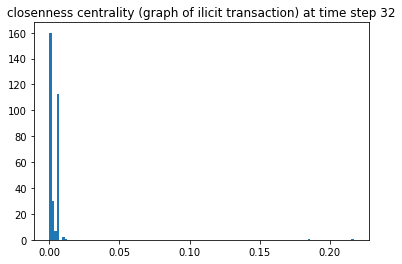

In [24]:
time_step = 32
number_licit_trans = df_class_feature[ (df_class_feature["class"] == '2') & (df_class_feature["Time step"] == time_step)].shape[0]
number_ilicit_trans = df_class_feature[ (df_class_feature["class"] == '1') & (df_class_feature["Time step"] == time_step)].shape[0]
print(f"Time step: {time_step}\nNumber of licit transactions: {number_licit_trans}\nNumber illicit transactions: {number_ilicit_trans}")

licit_ids = df_class_feature.loc[(df_class_feature['Time step'] == time_step) & (df_class_feature['class'] == '2'), 'txId']
licit_edges = df_edges.loc[df_edges['txId1'].isin(licit_ids)]

graph_l = nx.from_pandas_edgelist(licit_edges, source = 'txId1', target = 'txId2', 
                                 create_using = nx.DiGraph())

ilicit_ids = df_class_feature.loc[(df_class_feature['Time step'] == time_step) & (df_class_feature['class'] == '1'), 'txId']
ilicit_edges = df_edges.loc[df_edges['txId1'].isin(ilicit_ids)]

graph_ill = nx.from_pandas_edgelist(ilicit_edges, source = 'txId1', target = 'txId2', 
                                 create_using = nx.DiGraph())

# degree distribution (histogram of how many edges each node has)
plt.figure(1)
plt.title(f"Degree distribution graph of licit transaction at time step {time_step}")
plt.hist([v for k,v in nx.degree(graph_l)], bins="auto");

plt.figure(2)
plt.title(f"Degree distribution graph of illicit transaction at time step {time_step}")
plt.hist([v for k,v in nx.degree(graph_ill)],  bins="auto");

# betweenness centrality
plt.figure(3)
plt.title(f"betweenness centrality (graph of licit transaction) at time step {time_step}")
plt.hist(nx.centrality.betweenness_centrality(graph_l).values(),  bins="auto");
plt.savefig("./fig/betwl32.pdf")

plt.figure(4)
plt.title(f"betweenness centrality (graph of ilicit transaction at time step {time_step})")
plt.hist(nx.centrality.betweenness_centrality(graph_ill).values(),  bins="auto");
plt.savefig("./fig/betwil32.pdf")

# closeness centrality
plt.figure(5)
plt.title(f"closeness centrality (graph of licit transaction) at time step {time_step}")
plt.hist(nx.centrality.closeness_centrality(graph_l).values(),  bins="auto");

plt.figure(6)
plt.title(f"closenness centrality (graph of ilicit transaction) at time step {time_step}")
plt.hist(nx.centrality.closeness_centrality(graph_ill).values(),  bins="auto");
"""
# eigen vector centrality
plt.figure(7)
plt.title(f"eigen vector centrality (graph of licit transaction) at time step {time_step}")
plt.hist(nx.centrality.eigenvector_centrality(graph_l, max_iter= 500).values(),  bins="auto");

plt.figure(8)
plt.title(f"eigen vector centrality (graph of ilicit transaction) at time step {time_step}")
plt.hist(nx.centrality.eigenvector_centrality(graph_ill, max_iter= 2000).values(),  bins="auto");
"""
gc_l = nx.cluster.average_clustering(graph_l)
print(f"The global clustering coefficient for the licit graph is :{gc_l:.6f} at time step {time_step}")

gc_ill = nx.cluster.average_clustering(graph_ill)
print(f"The global clustering coefficient for the illicit graph is :{gc_ill:.6f} at time step {time_step}")



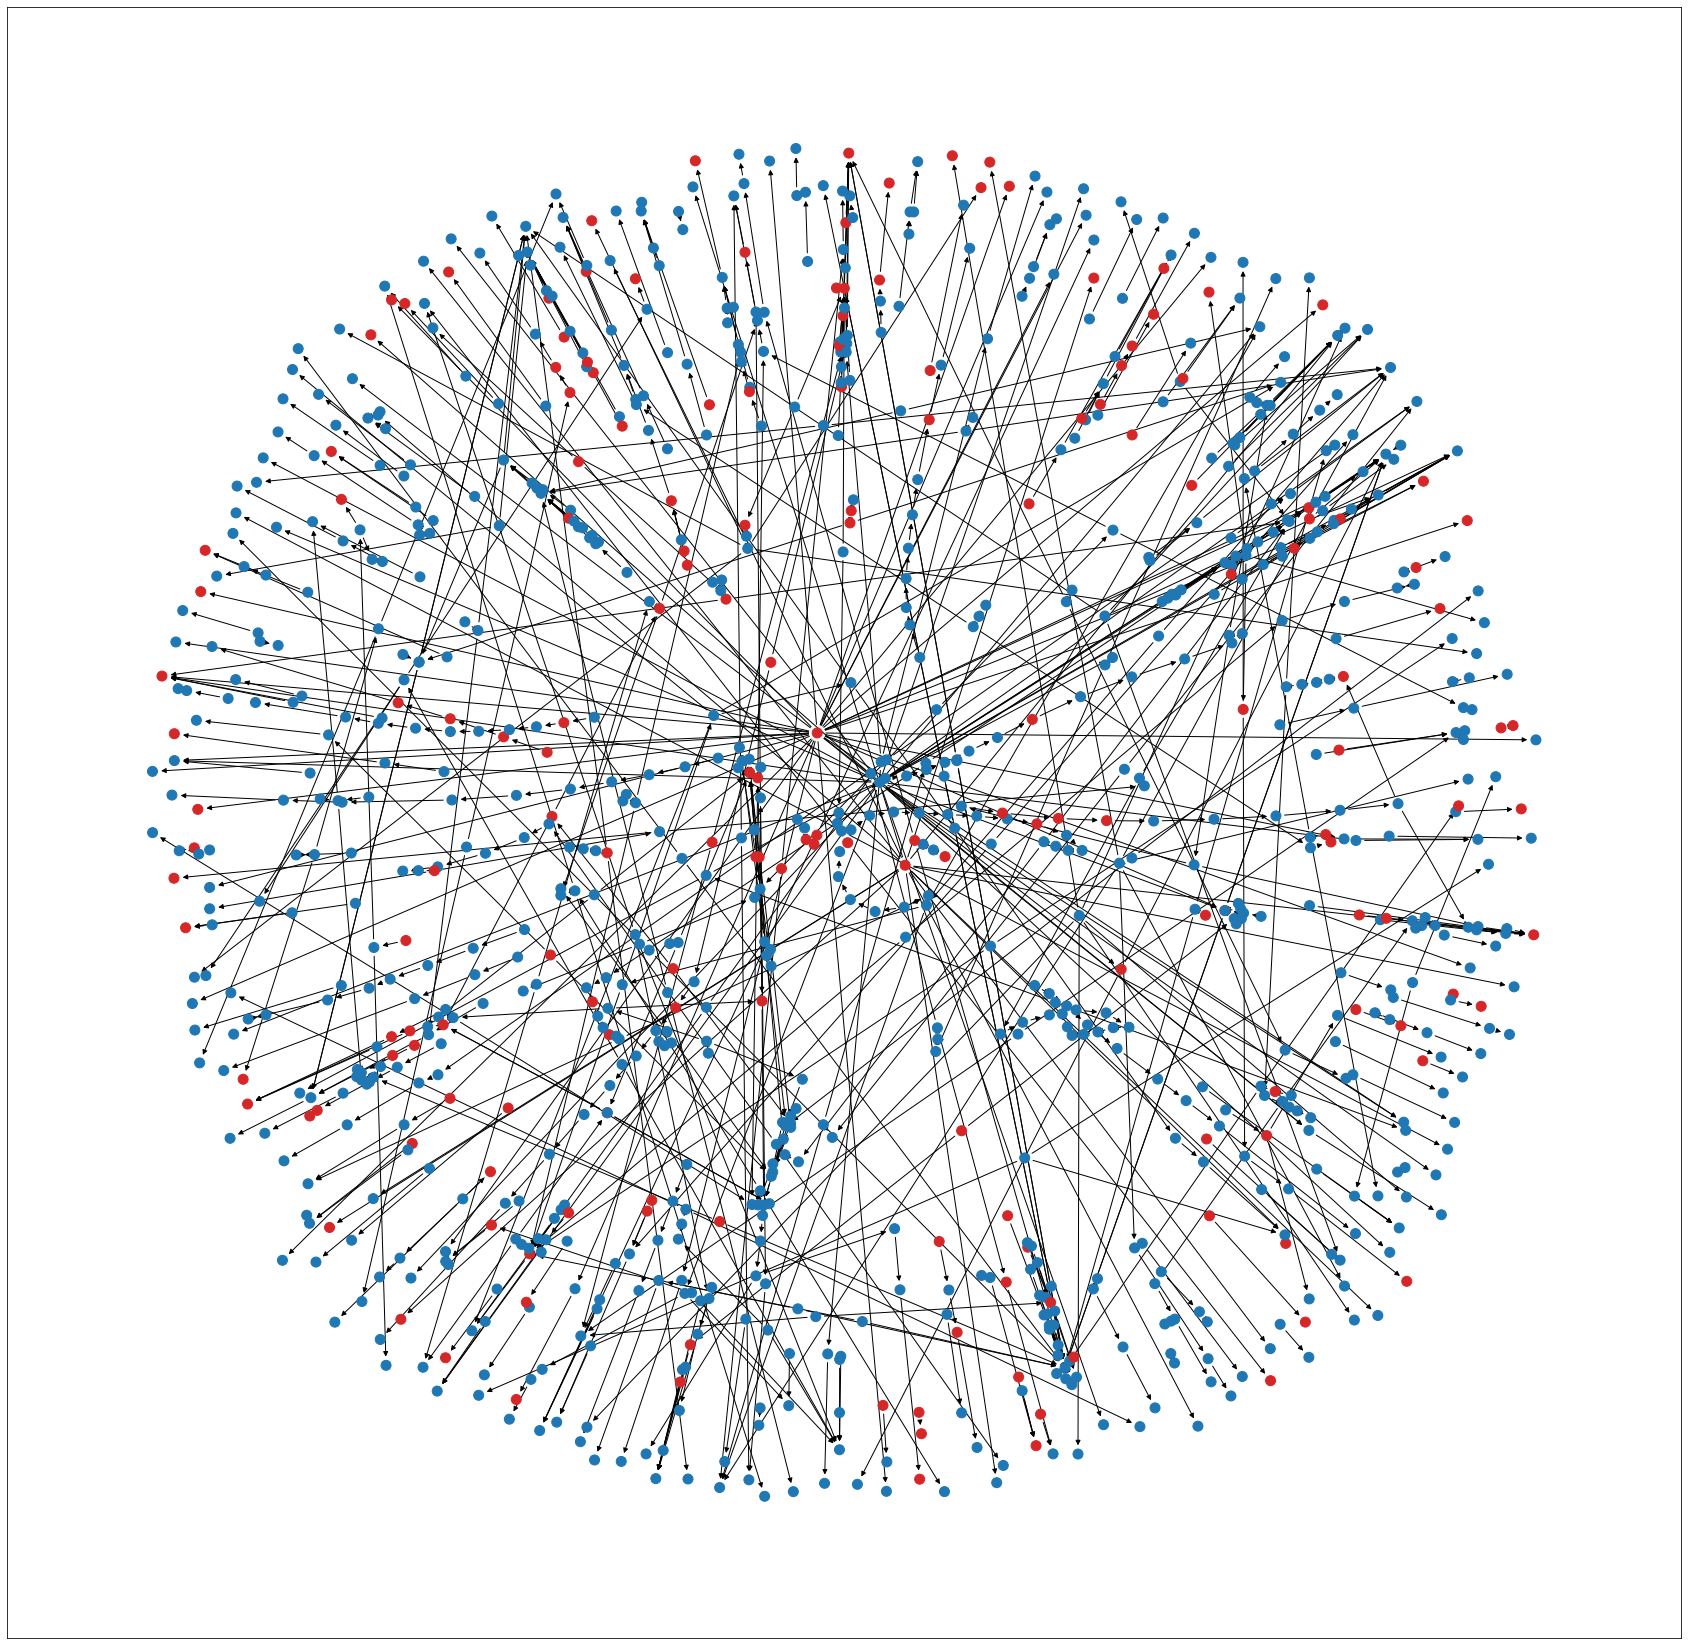

In [25]:
#visualizing the entire graph (both illicit and licit transactions) at time step 32
ids  = df_class_feature.loc[(df_class_feature['Time step'] == time_step) & (df_class_feature['class'] != 3), 'txId']
edges = df_edges.loc[(df_edges['txId1'].isin(ids)) & (df_edges['txId2'].isin(ids))]
graph_color = nx.from_pandas_edgelist(edges, source = 'txId1', target = 'txId2', 
                                 create_using = nx.DiGraph())
pos = nx.spring_layout(graph_color)
plt.figure(figsize=(30,30))
color = df_class_feature[df_class_feature["txId"].isin(list(graph_color.nodes))]["class"].replace({"1" :"tab:red", "2" : "tab:blue"})
nx.draw_networkx_nodes(graph_color, pos = pos, node_size = 100, node_color = color)
nx.draw_networkx_edges(graph_color, pos = pos)
plt.savefig("./fig/lic32.pdf")

In [26]:
# Graph of licit transactions at timestep 32 (the one with more illicit transactions among all time steps)

licit_ids = df_class_feature.loc[(df_class_feature['Time step'] == time_step) & (df_class_feature['class'] == '2'), 'txId']
licit_edges = df_edges.loc[df_edges['txId1'].isin(licit_ids)]

In [27]:
len(list((graph_l.nodes)))

1188

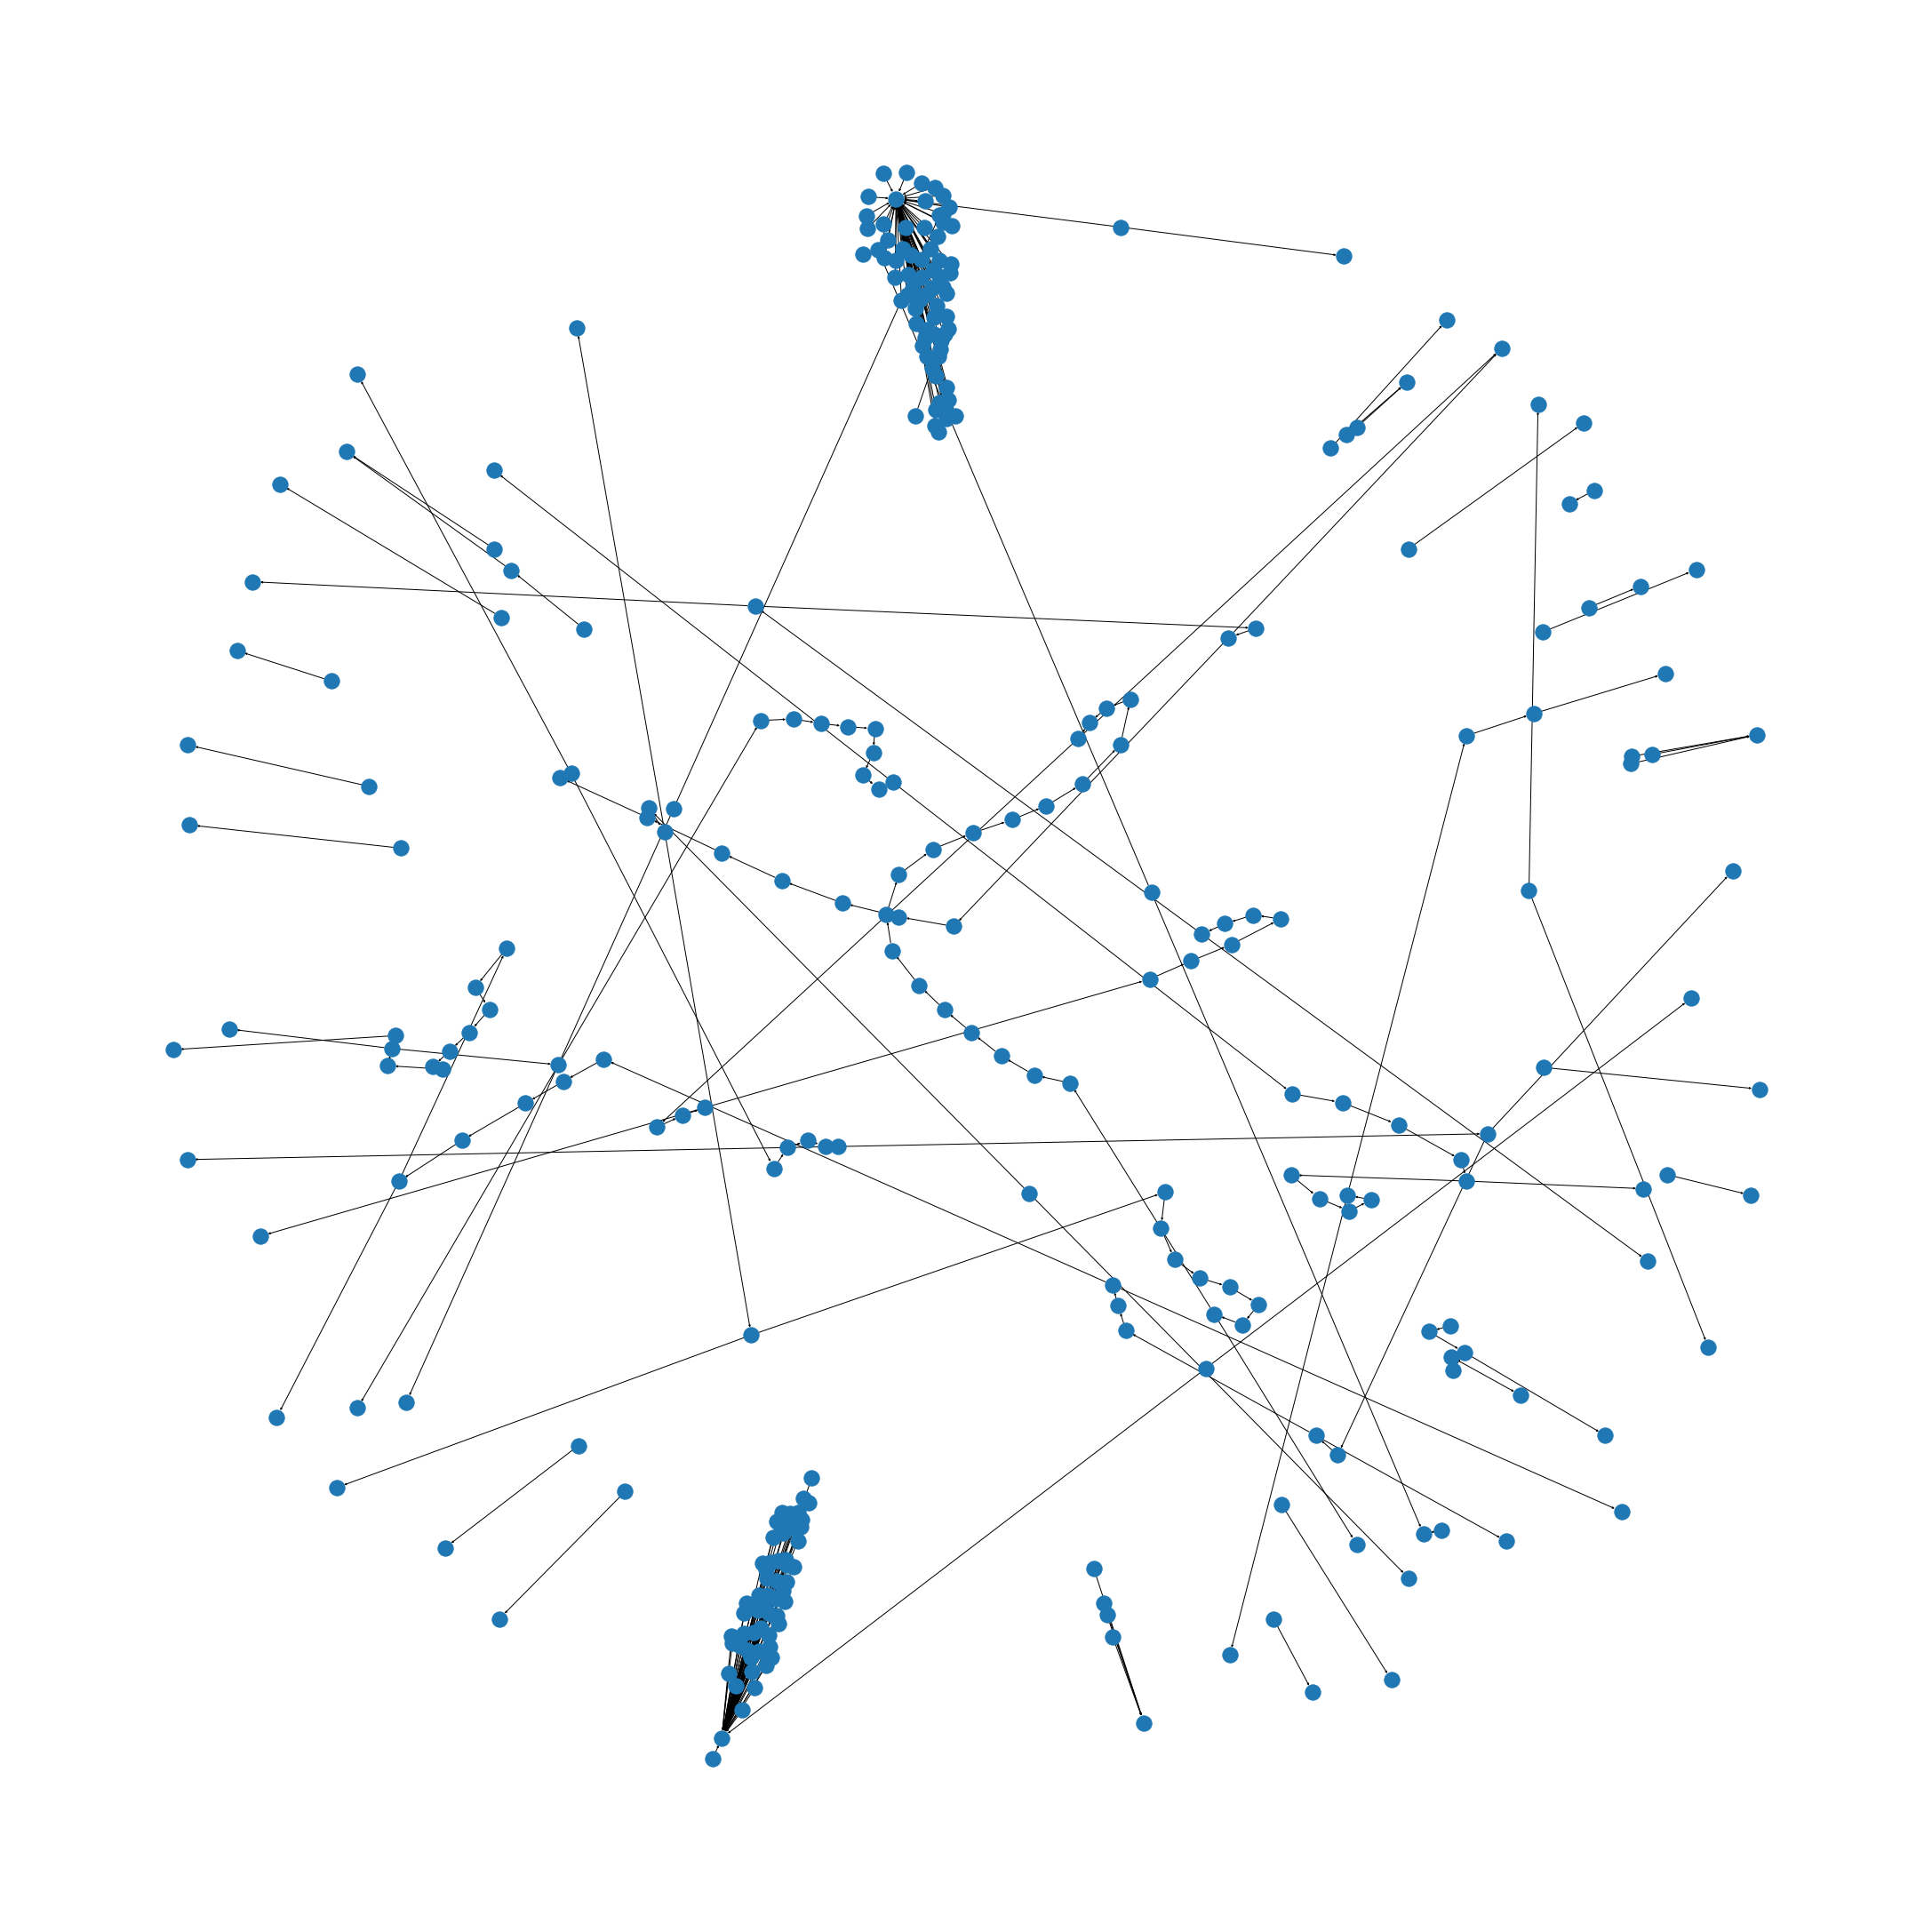

In [28]:
# Graph of illicit transactions at timestep 32 (the one with more illicit transactions among all time steps)

ilicit_ids = df_class_feature.loc[(df_class_feature['Time step'] == time_step) & (df_class_feature['class'] == '1'), 'txId']
ilicit_edges = df_edges.loc[df_edges['txId1'].isin(ilicit_ids)]

graph_ill = nx.from_pandas_edgelist(ilicit_edges, source = 'txId1', target = 'txId2', 
                                 create_using = nx.DiGraph())
pos = nx.spring_layout(graph_ill)
plt.figure(figsize=(30,30))
nx.draw(graph_ill, with_labels=False, pos=pos, arrowsize = 4)
plt.savefig("./fig/il32.pdf")

In [ ]:
#Visualization of all the graph for each time step

num_timestap = len(df_class_feature["Time step"].unique())

fig, axs = plt.subplots(7, 7, figsize = (40, 40))
i = 0
j = 0
for timestamp in range(1, num_timestap+1):
    ids = df_class_feature.loc[(df_class_feature['Time step'] == timestamp) & (df_class_feature['class'] == '1'), 'txId']
    edges = df_edges.loc[df_edges["txId1"].isin(ids)]

    graph = nx.from_pandas_edgelist(ilicit_edges, source="txId1", target = "txId2", create_using=nx.DiGraph())
    pos = nx.spring_layout(graph)
    
    # print(nx.degree(graph))
    # degree distribution (histogram of how many edges each node has)
    plt.figure(figsize=(35,35))
    #plt.hist([v for k,v in nx.degree(graph)]);
    nx.draw_networkx(graph, with_labels = False, pos = pos, ax=axs[i, j], node_size=100);
    j += 1
    if(timestamp % 7 == 0):
        i += 1
        j = 0

# TO COMPLETE
## Benchmark supervised methods
### Random Forest


In [ ]:
# we pick only class 1 and class 2
selected_ids = df_class_feature.loc[(df_class_feature['class'] != 3), 'txId']
df_edges_selected = df_edges.loc[df_edges['txId1'].isin(selected_ids)]
df_classes_selected = df_classes.loc[df_classes['txId'].isin(selected_ids)]
df_features_selected = df_features.loc[df_features['txId'].isin(selected_ids)]

# merge class and features
df_class_feature_selected = pd.merge(df_classes_selected, df_features_selected )
df_class_feature_selected.head(2)
df_class_feature_selected[:,0:1]

TypeError: '(slice(None, None, None), slice(0, 1, None))' is an invalid key

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=539b0cbd-1b67-4a6f-aaa0-1a7f2f688d10' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>